In [1]:
# general libraries
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# visualization
import seaborn as sns
import matplotlib.pyplot as plt


### Data Prep

In [2]:
cc_fraud = pd.read_csv('../data/full_fraud_dataset.csv',nrows=500000)
cc_fraud['full_name'] = cc_fraud['first'] + ' ' + cc_fraud['last']
print(cc_fraud.shape)

(500000, 26)


In [3]:
to_drop = ['ssn', 'cc_num', 'first', 'last', 'street', 'state', 'zip', 'acct_num', 'trans_num', 'unix_time']
cc_clean = cc_fraud.drop(to_drop, axis=1)

In [4]:
# pre-processing time
# transaction date
cc_clean['trans_datetime'] = pd.to_datetime(cc_clean['trans_date'])
cc_clean['trans_date'] = cc_clean['trans_datetime'].dt.date
cc_clean['trans_year'] = cc_clean['trans_datetime'].dt.year.astype(str)
cc_clean['trans_month'] = cc_clean['trans_datetime'].dt.month
cc_clean['trans_day'] = cc_clean['trans_datetime'].dt.day

# transaction time
cc_clean['trans_hour'] = cc_clean['trans_time'].str[:2].astype(int)

# convert month to string
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
cc_clean['trans_month_'] = cc_clean['trans_month'].map(month_map)

# convert time to part of day
def get_part_of_day(hour):
    """Return the part of day given the hour of day"""
    if (hour > 22) or (hour <= 6):
        return 'early morning'
    elif hour <= 11:
        return 'breakfast'
    elif hour <= 14:
        return 'lunch'
    elif hour <= 17:
        return 'afternoon'
    else:
        return 'dinner'
cc_clean.loc[:, 'part_of_day'] = cc_clean['trans_hour'].apply(get_part_of_day)

In [5]:
cc_clean['dob_datetime'] = pd.to_datetime(cc_clean['dob'])
cc_clean['dob'] = cc_clean['dob_datetime'].dt.date
cc_clean['age'] = (cc_clean['trans_date'] - cc_clean['dob'])/365
cc_clean['age'] = cc_clean['age'].apply(lambda x: x.days)

In [6]:
cc_clean['dob_datetime'] = pd.to_datetime(cc_clean['dob'])
cc_clean['dob'] = cc_clean['dob_datetime'].dt.date
cc_clean['age'] = (cc_clean['trans_date'] - cc_clean['dob'])/365
cc_clean['age'] = cc_clean['age'].apply(lambda x: x.days)

In [7]:
cc_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   gender          500000 non-null  object        
 1   city            500000 non-null  object        
 2   lat             500000 non-null  float64       
 3   long            500000 non-null  float64       
 4   city_pop        500000 non-null  int64         
 5   job             500000 non-null  object        
 6   dob             500000 non-null  object        
 7   trans_date      500000 non-null  object        
 8   trans_time      500000 non-null  object        
 9   category        500000 non-null  object        
 10  amt             500000 non-null  float64       
 11  is_fraud        500000 non-null  int64         
 12  merchant        500000 non-null  object        
 13  merch_lat       500000 non-null  float64       
 14  merch_long      500000 non-null  flo

## Exploratory Data Analysis

Number of transactions:


0    495509
1      4491
Name: is_fraud, dtype: int64

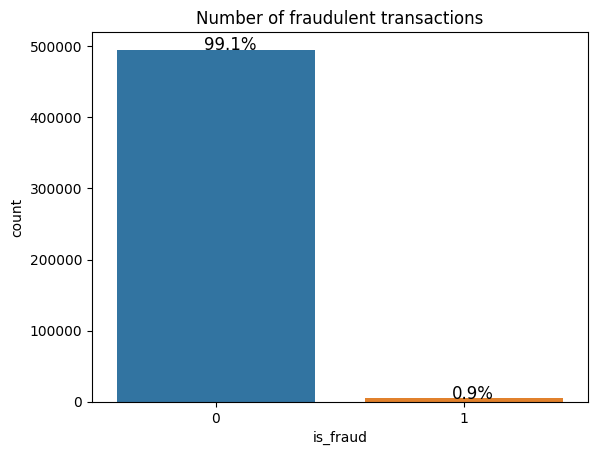

In [8]:
ax = sns.countplot(x='is_fraud',data=cc_clean)
plt.title("Number of fraudulent transactions")

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
        
without_hue(ax, cc_clean['is_fraud'])

print('Number of transactions:')
cc_clean['is_fraud'].value_counts()

Text(0.5, 1.0, 'Transactions by category')

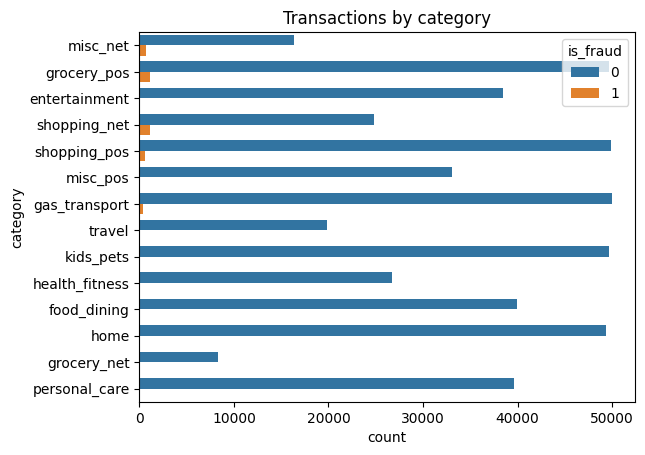

In [9]:
sns.countplot(y='category',hue= 'is_fraud',data=cc_clean)
plt.title('Transactions by category')

[Text(0.5, 1.0, 'Fraudulent transactions by category')]

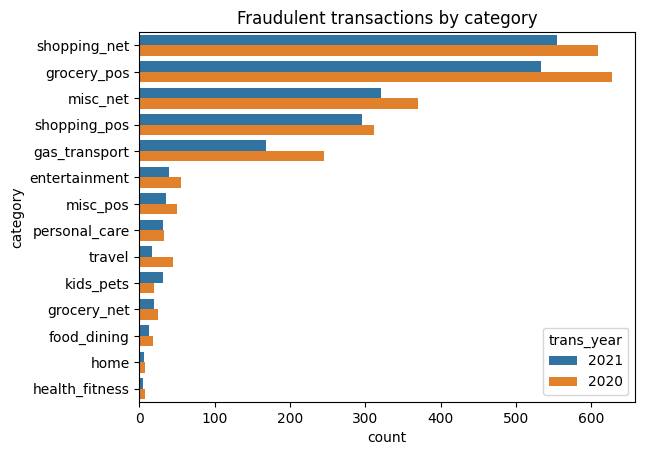

In [10]:
sns.countplot(y='category',hue= 'trans_year',data=cc_clean[cc_clean['is_fraud'] == 1],
             order = cc_clean[cc_clean['is_fraud'] == 1]['category'].value_counts().index).set(
    title = 'Fraudulent transactions by category'
)            

[Text(0.5, 1.0, 'Transactions per month')]

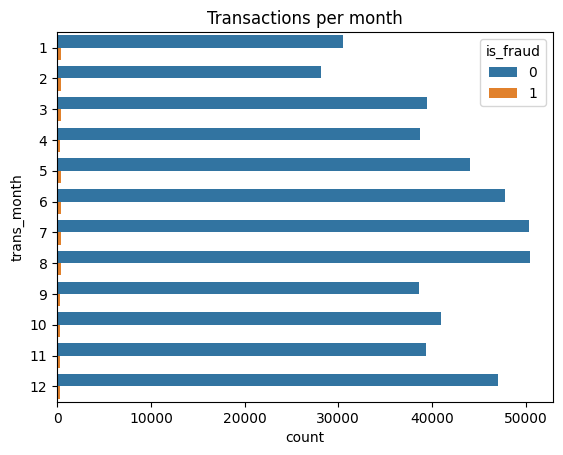

In [11]:
sns.countplot(y='trans_month',hue= 'is_fraud',data=cc_clean).set(title ='Transactions per month')

[Text(0.5, 1.0, 'Number of Fraud Transactions per Month')]

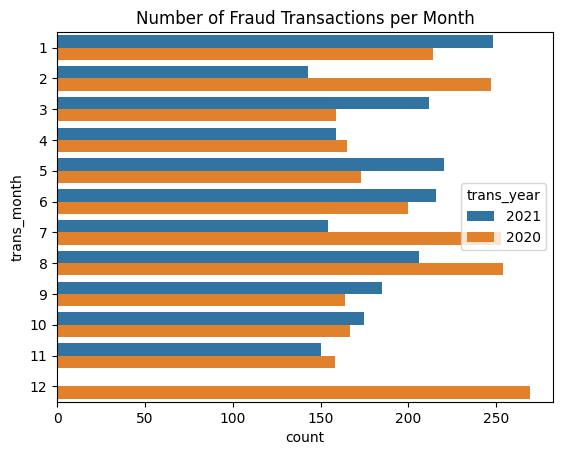

In [12]:
sns.countplot(y='trans_month',hue= 'trans_year',data=cc_clean[cc_clean['is_fraud'] == 1]).set(title = 'Number of Fraud Transactions per Month')

In [13]:
mem_summary = cc_clean[['full_name', 'is_fraud', 'trans_year']]
mem_transactions = pd.DataFrame(mem_summary.groupby(['full_name']).count()['is_fraud']).reset_index()
mem_transactions = mem_transactions.rename(columns={"is_fraud":"trans_count"})

In [14]:
mem_fraud_cnt = pd.DataFrame(mem_summary[mem_summary['is_fraud'] == 1].groupby(['full_name']).count()['is_fraud']).reset_index()
mem_fraud_cnt = mem_fraud_cnt.rename(columns={"is_fraud":"fraud_count"})

In [15]:
mem_trans_cnt = mem_transactions.merge(mem_fraud_cnt, on = 'full_name', how = 'outer')
mem_trans_cnt['perc_fraud'] = 100*(mem_trans_cnt['fraud_count']/mem_trans_cnt['trans_count'])
mem_trans_cnt['w_fraud'] = np.where(mem_trans_cnt['fraud_count']>0, 1, 0)
mem_trans_cnt

,full_name,trans_count,fraud_count,perc_fraud,w_fraud
0,Aaron Chase,2102,9.0,0.428164,1
1,Aaron Heath,711,7.0,0.984529,1
2,Aaron Suarez,1415,10.0,0.706714,1
3,Aaron Walker,10,10.0,100.000000,1
4,Adam Brown,2123,12.0,0.565238,1
...,...,...,...,...,...
465,Willie Davis,1418,10.0,0.705219,1
466,Wyatt Davis,1417,8.0,0.564573,1
467,Zachary Andrews,11,11.0,100.000000,1
468,Zachary Johnson,2113,7.0,0.331283,1


Average number of transactions per person: 1063.83
Minimum number of transactions: 7
Maximum number of transactions: 3532

Number of people with all fraud transactions: 117
Minimum fraud transaction count (all_fraud): 7.0
Maximum fraud transaction count (all_fraud): 12.0


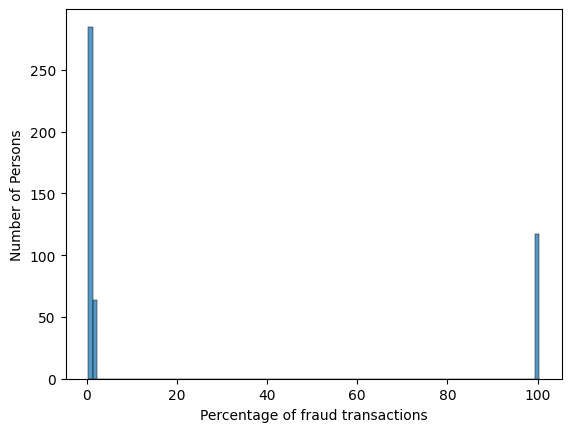

In [26]:
sns.histplot(data = mem_trans_cnt, x = 'perc_fraud', binwidth = 1)
plt.xlabel('Percentage of fraud transactions')
plt.ylabel('Number of Persons')

print ("Average number of transactions per person:", round(np.mean(mem_trans_cnt['trans_count']),2))
print ("Minimum number of transactions:", min(mem_trans_cnt['trans_count']))
print ("Maximum number of transactions:", max(mem_trans_cnt['trans_count']))

all_fraud_mems = mem_trans_cnt[mem_trans_cnt['perc_fraud'] == 100]
print ("\nNumber of people with all fraud transactions:", len(all_fraud_mems))
print ("Minimum fraud transaction count (all_fraud):", min(all_fraud_mems['fraud_count']))
print ("Maximum fraud transaction count (all_fraud):", max(all_fraud_mems['fraud_count']))

Number of people with less than 50% fraud transactions: 349
Max percentage(%) of fraud transactions: 1.68


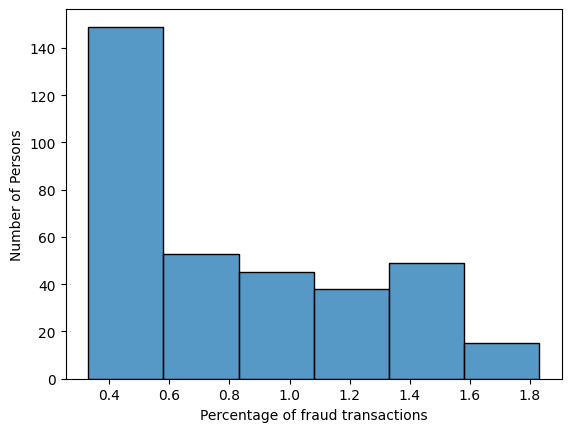

In [17]:
less_50_perc_fraud = mem_trans_cnt[mem_trans_cnt['perc_fraud'] < 50]
sns.histplot(data = less_50_perc_fraud, x = 'perc_fraud', binwidth = 0.25)
plt.xlabel('Percentage of fraud transactions')
plt.ylabel('Number of Persons')

print ("Number of people with less than 50% fraud transactions:", len(less_50_perc_fraud))
print ("Max percentage(%) of fraud transactions:", round(max(less_50_perc_fraud['perc_fraud']), 2))

Text(0.5, 1.0, 'Number of individuals with fraud transactions')

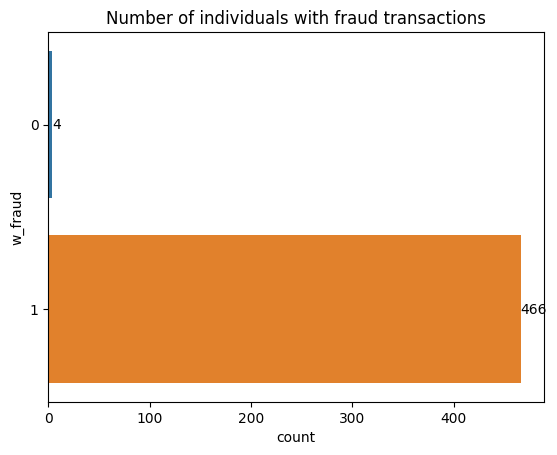

In [18]:
ax =sns.countplot(y='w_fraud',data=mem_trans_cnt)
ax.bar_label(ax.containers[0])
plt.title('Number of individuals with fraud transactions')

## Summary of different models

| Model | Parameters Tuned | Best Model Parameters | Accuracy | Run time |
| --- | --- | --- | --: | --- |
| Logistic Regression | Random_state: [1 to 10] <br>Alpha: [1e-11, 1e-10,1e-9,1e-8, 1e-5, 1e-3, 0.1] | Random_state: 10<br> Alpha: 1e-10 | 99.08 | 3 mins 34 secs |
| KNN Classifier | n_neighbors: [2 to 6] <br> data split: train-test split, 5-fold crossvalidation| n_neighbors (train-test split): 2 <br> n_neighbors (crossvalidation): 6 | 99.31 <br> 90.79 | 5mins 38secs* <br>  51mins 54 secs|
| Decision Trees | --- | --- | --- | --- |
| Random Forest | max_depth = [1 to 10] <br>n_estimators = [1 to 10] <br><br> max_depth = [1 to 10]<br>max_features = [60, 80, 100, 120, 140]| max_depth = --- <br>n_estimators = --- <br><br> max_depth = ---<br>max_features = --- | 99.08<br><br><br>99.19 | 3mins 28secs<br><br><br>16mins 44secs |
| Gradient Boosting | learning_rate = [0.1 to 0.3] <br>max_depth = [1 to 10] <br>n_estimators = [1 to 100] <br><br> learning_rate = [0.1 to 0.3] <br>max_depth = [1 to 10] <br><br> max_depth = [1 to 10] | learning_rate = --- <br>max_depth = --- <br>n_estimators = --- <br><br> learning_rate = --- <br>max_depth = --- <br><br> max_depth = --- |  --- <br><br><br><br> --- <br><br><br><br> ---  | --- <br><br><br><br> --- <br><br><br><br> ---  |
| Ada Boosting | n_estimators = [1 to 10]<br>random_state = [1 to 10]<br>**tried learning rate, interestingly accuracy is terrible (<1%)| n_estimators = 7<br>random_state = 7 | 99.77 | 10 minutes 47 seconds |
| ExtraTreesBoosting | max_depth = [1 to 10] <br> n_estimators = 100 <br> random_state = [1 to 10]| max_depth = --- <br> n_estimators = 100 <br> random_state = --- | 99.05 | 23 minutes 40.3 seconds |
###### * fitted on 10,000 rows only. fitting on 100,000 rows takes more than 2hrs then crashes 


## Interesting insights

**EDA**
- d
- b

**Model Tuning**
- d
- b

## Hypertuning of different models

In [ ]:
df = pd.read_csv('data/cc_df.csv', nrows=100000)
df.head()

X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']

### Random Forest

#### Using '**max_depth**' and '**n_estimators**' parameters

In [ ]:
# modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import pickle

In [ ]:
all_training = pd.DataFrame()
all_test = pd.DataFrame()
# Setting random state
RNDM_STATE = 42

max_depth_settings = range(1, 11)
for depth in tqdm(max_depth_settings):
    (X_train, X_test, y_train, y_test) = train_test_split(X, 
                                                    y, 
                                                    random_state=RNDM_STATE, 
                                                    test_size=0.25)
    
    training_accuracy = []
    test_accuracy = []
    n_estimators_settings = range(1, 11)
    for trees_n in tqdm(n_estimators_settings):
        rf_depth_estimators = RandomForestClassifier(max_depth=depth, n_estimators=trees_n, random_state=RNDM_STATE)
        rf_depth_estimators.fit(X_train, y_train)
        
        training_accuracy.append(rf_depth_estimators.score(X_train, y_train))
        test_accuracy.append(rf_depth_estimators.score(X_test, y_test))
        
    all_training[depth] = training_accuracy
    all_test[depth] = test_accuracy

In [ ]:
fig = plt.figure(figsize=(15,8))
plt.errorbar(n_estimators_settings, all_training.mean(axis=1), yerr=all_training.std(axis=1), label='Training Accuracy')
plt.errorbar(n_estimators_settings, all_test.mean(axis=1), yerr=all_test.std(axis=1), label='Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.legend()

best_n_est = np.argmax(all_test.mean(axis=1)) + 1
print(f'Highest Average Test Set Accuracy = {np.max(all_test.mean(axis=1)):.4%}')
print(f'Best n_estimator parameter = {best_n_est}')

In [ ]:
df = pd.DataFrame({'features': X.columns, 'prob': rf_depth_estimators.feature_importances_})
df.sort_values(['prob'], ascending=False)[:10]